# Notebook to plot relation between orbital and structural properties of satellites with Gaia data

In [1]:
import matplotlib
import pandas as pd
import numpy as np
from satellite_properties_plot_utils import *

## Gaia data from Table 2 and Table 4 in [Andrade et al. 2023](https://arxiv.org/abs/2311.01528)

In [2]:
GAIA_PATH = "../data/Gaia/"

density_Andrade = pd.read_csv(GAIA_PATH+"density150pc_Andrade2023.csv")

# e.g. --- 0 = measurement [10^7 Msolar], 1 = lower error [10^7 Msolar], 2 = upper error [10^7 Msolar]
density_Andrade

,Draco,Fornax,Carina,CVnI,LeoI,LeoII,Sculptor,Sextans,UrsaMinor
0,18.8,4.8,4.7,10.5,20.7,17.1,14.7,6.8,17.5
1,2.7,0.5,0.7,3.7,2.9,2.0,2.0,1.9,5.2
2,3.7,0.9,0.9,5.4,2.9,2.1,1.8,2.8,7.3


In [3]:
# To numpy
density_Andrade = pd.read_csv(GAIA_PATH+"density150pc_Andrade2023.csv").to_numpy() * 1e7
density_Hayashi = pd.read_csv(GAIA_PATH+"density150pc_Hayashi2020.csv").to_numpy() * 1e7
density_Kaplinghat_nfw = pd.read_csv(GAIA_PATH+"density150pc_Kaplinghat2019_nfw.csv").to_numpy() * 1e7
density_Kaplinghat_iso = pd.read_csv(GAIA_PATH+"density150pc_Kaplinghat2019_iso.csv").to_numpy() * 1e7
density_Read = pd.read_csv(GAIA_PATH+"density150pc_Read2019.csv").to_numpy() * 1e7

pericenter_Battaglia = pd.read_csv(GAIA_PATH+"pericenter_Battaglia2020.csv").to_numpy()

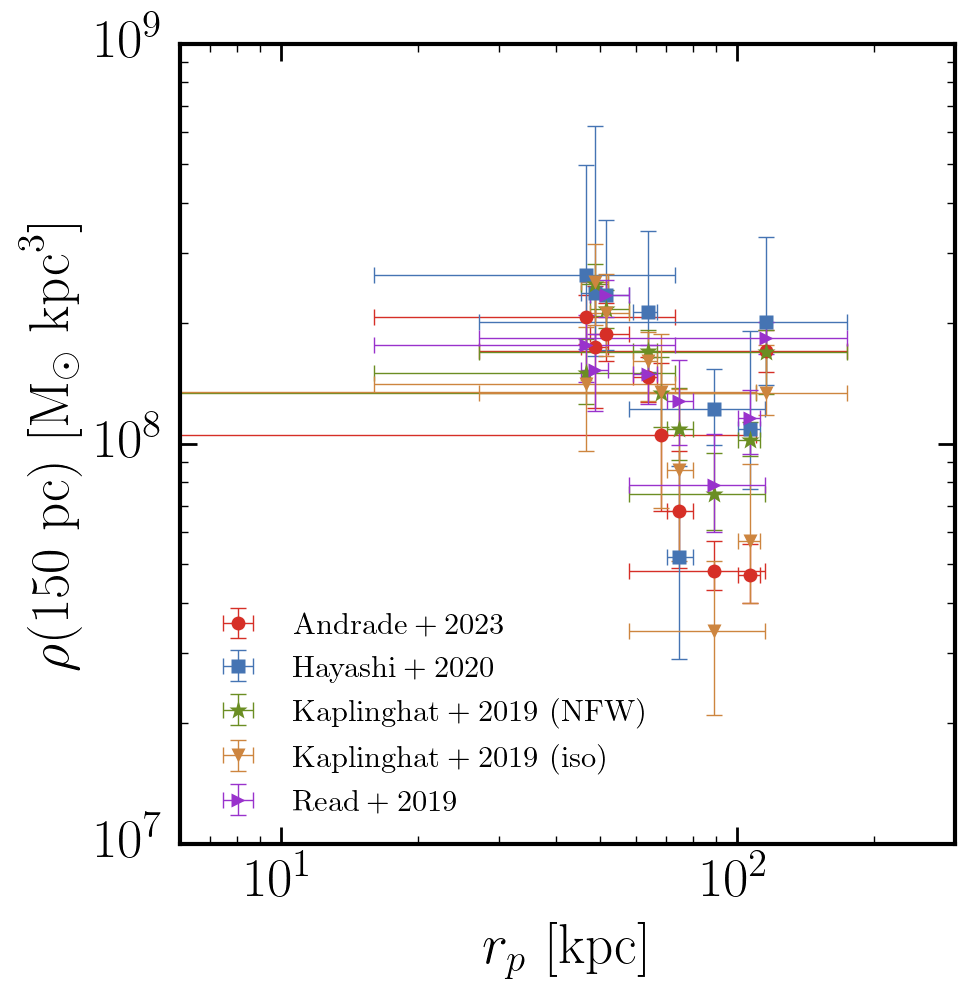

In [103]:
plt.style.use("pltstyle.mplstyle")

x = pericenter_Battaglia[0]
xerr = pericenter_Battaglia[1:]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor='white', dpi=200)

ax.errorbar(x, density_Andrade[0], yerr=density_Andrade[1:], xerr=xerr, 
            marker='o', markersize=5, markeredgecolor="none", ls='none', 
            lw=0.5, c=myblue, alpha=1, label=r'$\mathrm{Andrade+2023}$')

ax.errorbar(x, density_Hayashi[0], yerr=density_Hayashi[1:], xerr=xerr, 
            marker='s', markersize=5, markeredgecolor="none", ls='none', 
            lw=0.5, c=myred, alpha=1, label=r'$\mathrm{Hayashi+2020}$')

ax.errorbar(x, density_Kaplinghat_nfw[0], yerr=density_Kaplinghat_nfw[1:], xerr=xerr, 
            marker='*', markersize=7, markeredgecolor="none", ls='none', 
            lw=0.5, c='olivedrab', alpha=1, label=r'$\mathrm{Kaplinghat+2019\ (NFW)}$')

ax.errorbar(x, density_Kaplinghat_iso[0], yerr=density_Kaplinghat_iso[1:], xerr=xerr, 
            marker='v', markersize=5, markeredgecolor="none", ls='none', 
            lw=0.5, c='peru', alpha=1, label=r'$\mathrm{Kaplinghat+2019\ (iso)}$')

ax.errorbar(x, density_Read[0], yerr=density_Read[1:], xerr=xerr, 
            marker='>', markersize=5, markeredgecolor="none", ls='none', 
            lw=0.5, c='darkorchid', alpha=1, label=r'$\mathrm{Read+2019}$')

ax.set_xlim(6, 300)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
ax.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^3]$')
ax.legend(fontsize=11, numpoints=1)
fig.savefig("Observational_data.png",dpi=300)

## Density at 150pc from TangoSIDM satellites

In [5]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
    "SigmaConstant10": "SigmaConstant10",
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

#### Plotting routine A

- `colorbar_param`: points can be color coded with a colorbar by `accretion` (accretion redshift), `mass_peak` (peak mass), `mass_0` (bounded mass at z=0), and `mass_parent` (the virial mass of the parent host halo).

- <mark> `data`: measurment points from Gaia datasets (e.g., `density_Andrade[0]`, `density_Hayashi[0]`, `density_Kaplinghat_nfw[0]`, `density_Kaplinghat_iso[0]`, `density_Read[0]`). The pericenter data comes from `pericenter_Battaglia`.<mark>

- `dataerr`: error of measurment points from Gaia datasets (lower, upper), (e.g., `density_Andrade[1:]`, `density_Hayashi[1:]`, `density_Kaplinghat_nfw[1:]`, `density_Kaplinghat_iso[1:]`, `density_Read[1:]`)

- `zoom` (bool): if True makes x and y axis limits smaller, zooming in the region where datapoints are.

- `max10` (bool): if True only considers the 10 most massive satellites per host halos.

In [104]:
def plot_density_150pc_with_data(colorbar_param:str, data:np.array, dataerr:np.array, zoom:bool=False, max10:str=False):
    
    print(f'Plotting density at 150pc versus pericenter distance with {colorbar_param} colorbar with Gaia data!')

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=zoom, figsize=(13, 8), dpi=200, facecolor='white')
    axs = axs.flatten()

    for i, (id, id_name) in enumerate(IDs.items()):
        file = h5py.File(DATA_PATH+f"{id}.hdf5", "r")
        p_array, r_array, c_array = [], [], []
        
        if zoom:
            axs[i].text(8, 3.5e8,  fr'$\texttt{{{id_name}}}$', color='black', 
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2')) #, horizontalalignment='right')
        else:
            if i ==0:
                axs[i].text(1e3, 2e7,  fr'$\texttt{{{id_name}}}$', color='black', 
                    bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), horizontalalignment='right')
            else:
                axs[i].text(1e3, 2e6,  fr'$\texttt{{{id_name}}}$', color='black', 
                    bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), horizontalalignment='right')

        axs[i].errorbar(x, data, yerr=dataerr, xerr=xerr, ls='none', c='k')
        
        for idx in file.keys():
            if file[f'{idx}'].attrs.get('main_halo_of') is not None:
                halo_idx = idx
                data_halo = file[f'{halo_idx}']
                subhalos_idxs = file[f'{halo_idx}'].attrs.get('main_halo_of')

                if max10: r = min(len(subhalos_idxs), 10)
                else: r = len(subhalos_idxs)
                
                for subhalo in range(r):
                    subhalo_idx = subhalos_idxs[subhalo]
                    data_subhalo = file[f'{subhalo_idx}']

                    if np.log10(data_subhalo['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                        pericenter = data_subhalo['tree_data']['pericenter'][1]
                        z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']

                        if id_name == "CDM":
                            r0, rho0 = data_subhalo['halo_data']['nfw_fit']
                            density_fit = fit_nfw_model(np.array([0.15]), r0, rho0)
                            density_fit = 10**density_fit
                        else:
                            r0, rho0 = data_subhalo['halo_data']['iso_fit']
                            density_fit = fit_isothermal_model(np.array([0.15]*2), r0, rho0)[0]
                            density_fit = 10**density_fit

                        if colorbar_param == 'accretion':
                            c = accretion
                            cmap, norm = colorbar_args(colorbar_param)
                        elif colorbar_param == 'mass_0':
                            mass_0 = data_subhalo['tree_data']['bound_mass_dm'][0] 
                            c = np.log10(mass_0)
                            cmap, norm = colorbar_args(colorbar_param)
                        elif colorbar_param == 'mass_peak':
                            mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]
                            c = np.log10(mass_peak)
                            cmap, norm = colorbar_args(colorbar_param)
                        elif colorbar_param == 'mass_parent':
                            mass_parent = data_halo['tree_data']['bound_mass_dm'][0] 
                            c = np.log10(mass_parent)
                            vmin, vmax = np.log10(6e11), np.log10(2e12)
                            cmap =  matplotlib.colors.ListedColormap(matplotlib.cm.Blues(np.linspace(0.2, 1, 5)))
                            norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=((vmax+vmin)/2), vmax=vmax)
                
                        p = pericenter[0] if pericenter.shape==(1,) else pericenter
                        im = axs[i].scatter(x=pericenter, y=density_fit, marker='o', linewidths=0, 
                                            c=c, cmap=cmap, norm=norm, alpha=0.7)
                        p_array.append(p)
                        r_array.append(density_fit)
                        c_array.append(c)
        file.close() 
                      
    # axis stuff
    for i, ax in enumerate(axs):
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if zoom:
            ax.set_xlim(6e0, 5e2)
            ax.set_ylim(2e7, 5e8)
        else: 
            ax.set_xlim(6e0, 1.5e3)
            if i ==0:
                ax.set_ylim(1e7, 2e9)
            else:
                ax.set_ylim(1e6, 3e8)
            
    for axi in [3, 4, 5]:
        axs[axi].set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    for axi in [0, 3]:
        axs[axi].set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^3]$')
                
    # colorbar stuff
    if colorbar_param == "accretion":
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=COLORBAR_DICT[colorbar_param], aspect=40, fraction=0.02, pad=0.04)
        cbar.ax.set_yticks([0, 1, 2]) 
    elif colorbar_param in ["mass_0", "mass_peak"]:
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=COLORBAR_DICT[colorbar_param], aspect=40, fraction=0.02, pad=0.04)
        cbar.ax.set_yticks([9, 10, 11, 12]) 
    elif colorbar_param == "mass_parent":
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=fr'$\log_{{10}}\mathrm{{M_{{200c, central}}}}$ $\mathrm{{[M_\odot]}}$',
                        aspect=40, fraction=0.02, pad=0.04)
        
    if zoom:
        plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)
    else:
        plt.subplots_adjust(hspace=0.2, wspace=0.2, right=.86)
    plt.show()

Plotting density at 150pc versus pericenter distance with mass_parent colorbar with Gaia data!


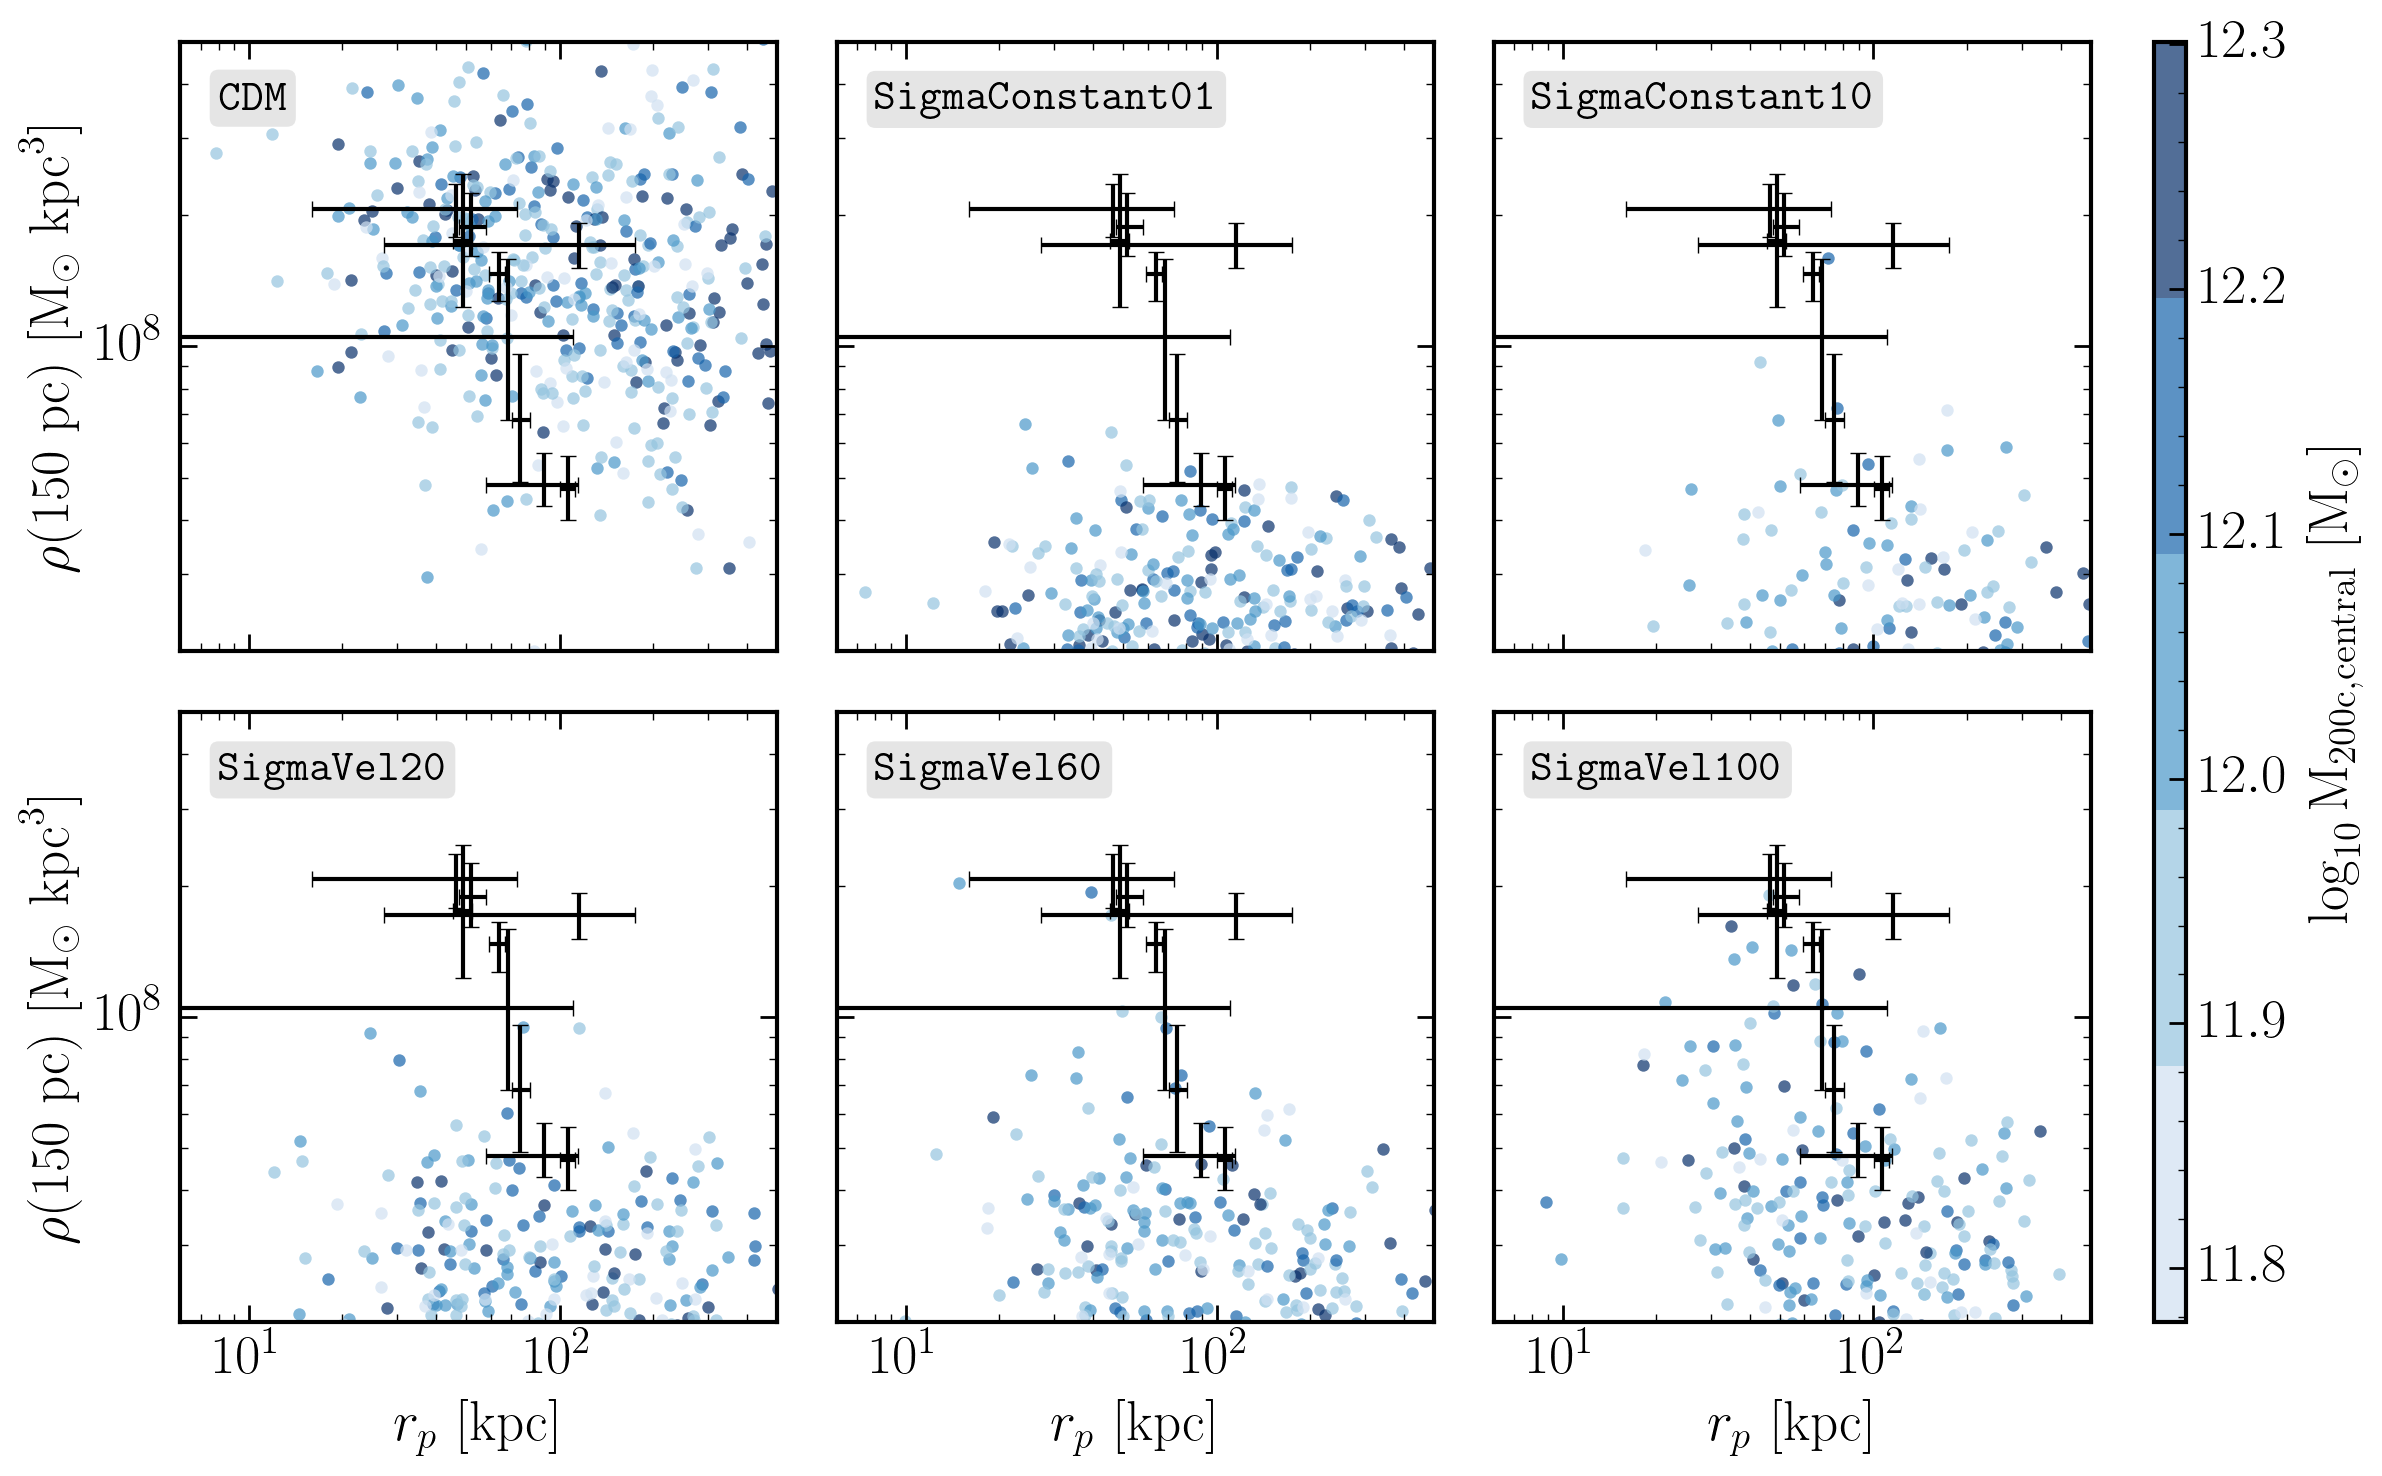

In [105]:
plot_density_150pc_with_data(colorbar_param="mass_parent", zoom=True, data=density_Andrade[0], dataerr=density_Andrade[1:])

In [ ]:
plot_density_150pc_with_data(colorbar_param="mass_parent", zoom=True, data=density_Andrade[0], dataerr=density_Andrade[1:])

Plotting density at 150pc versus pericenter distance with mass_peak colorbar with Gaia data!


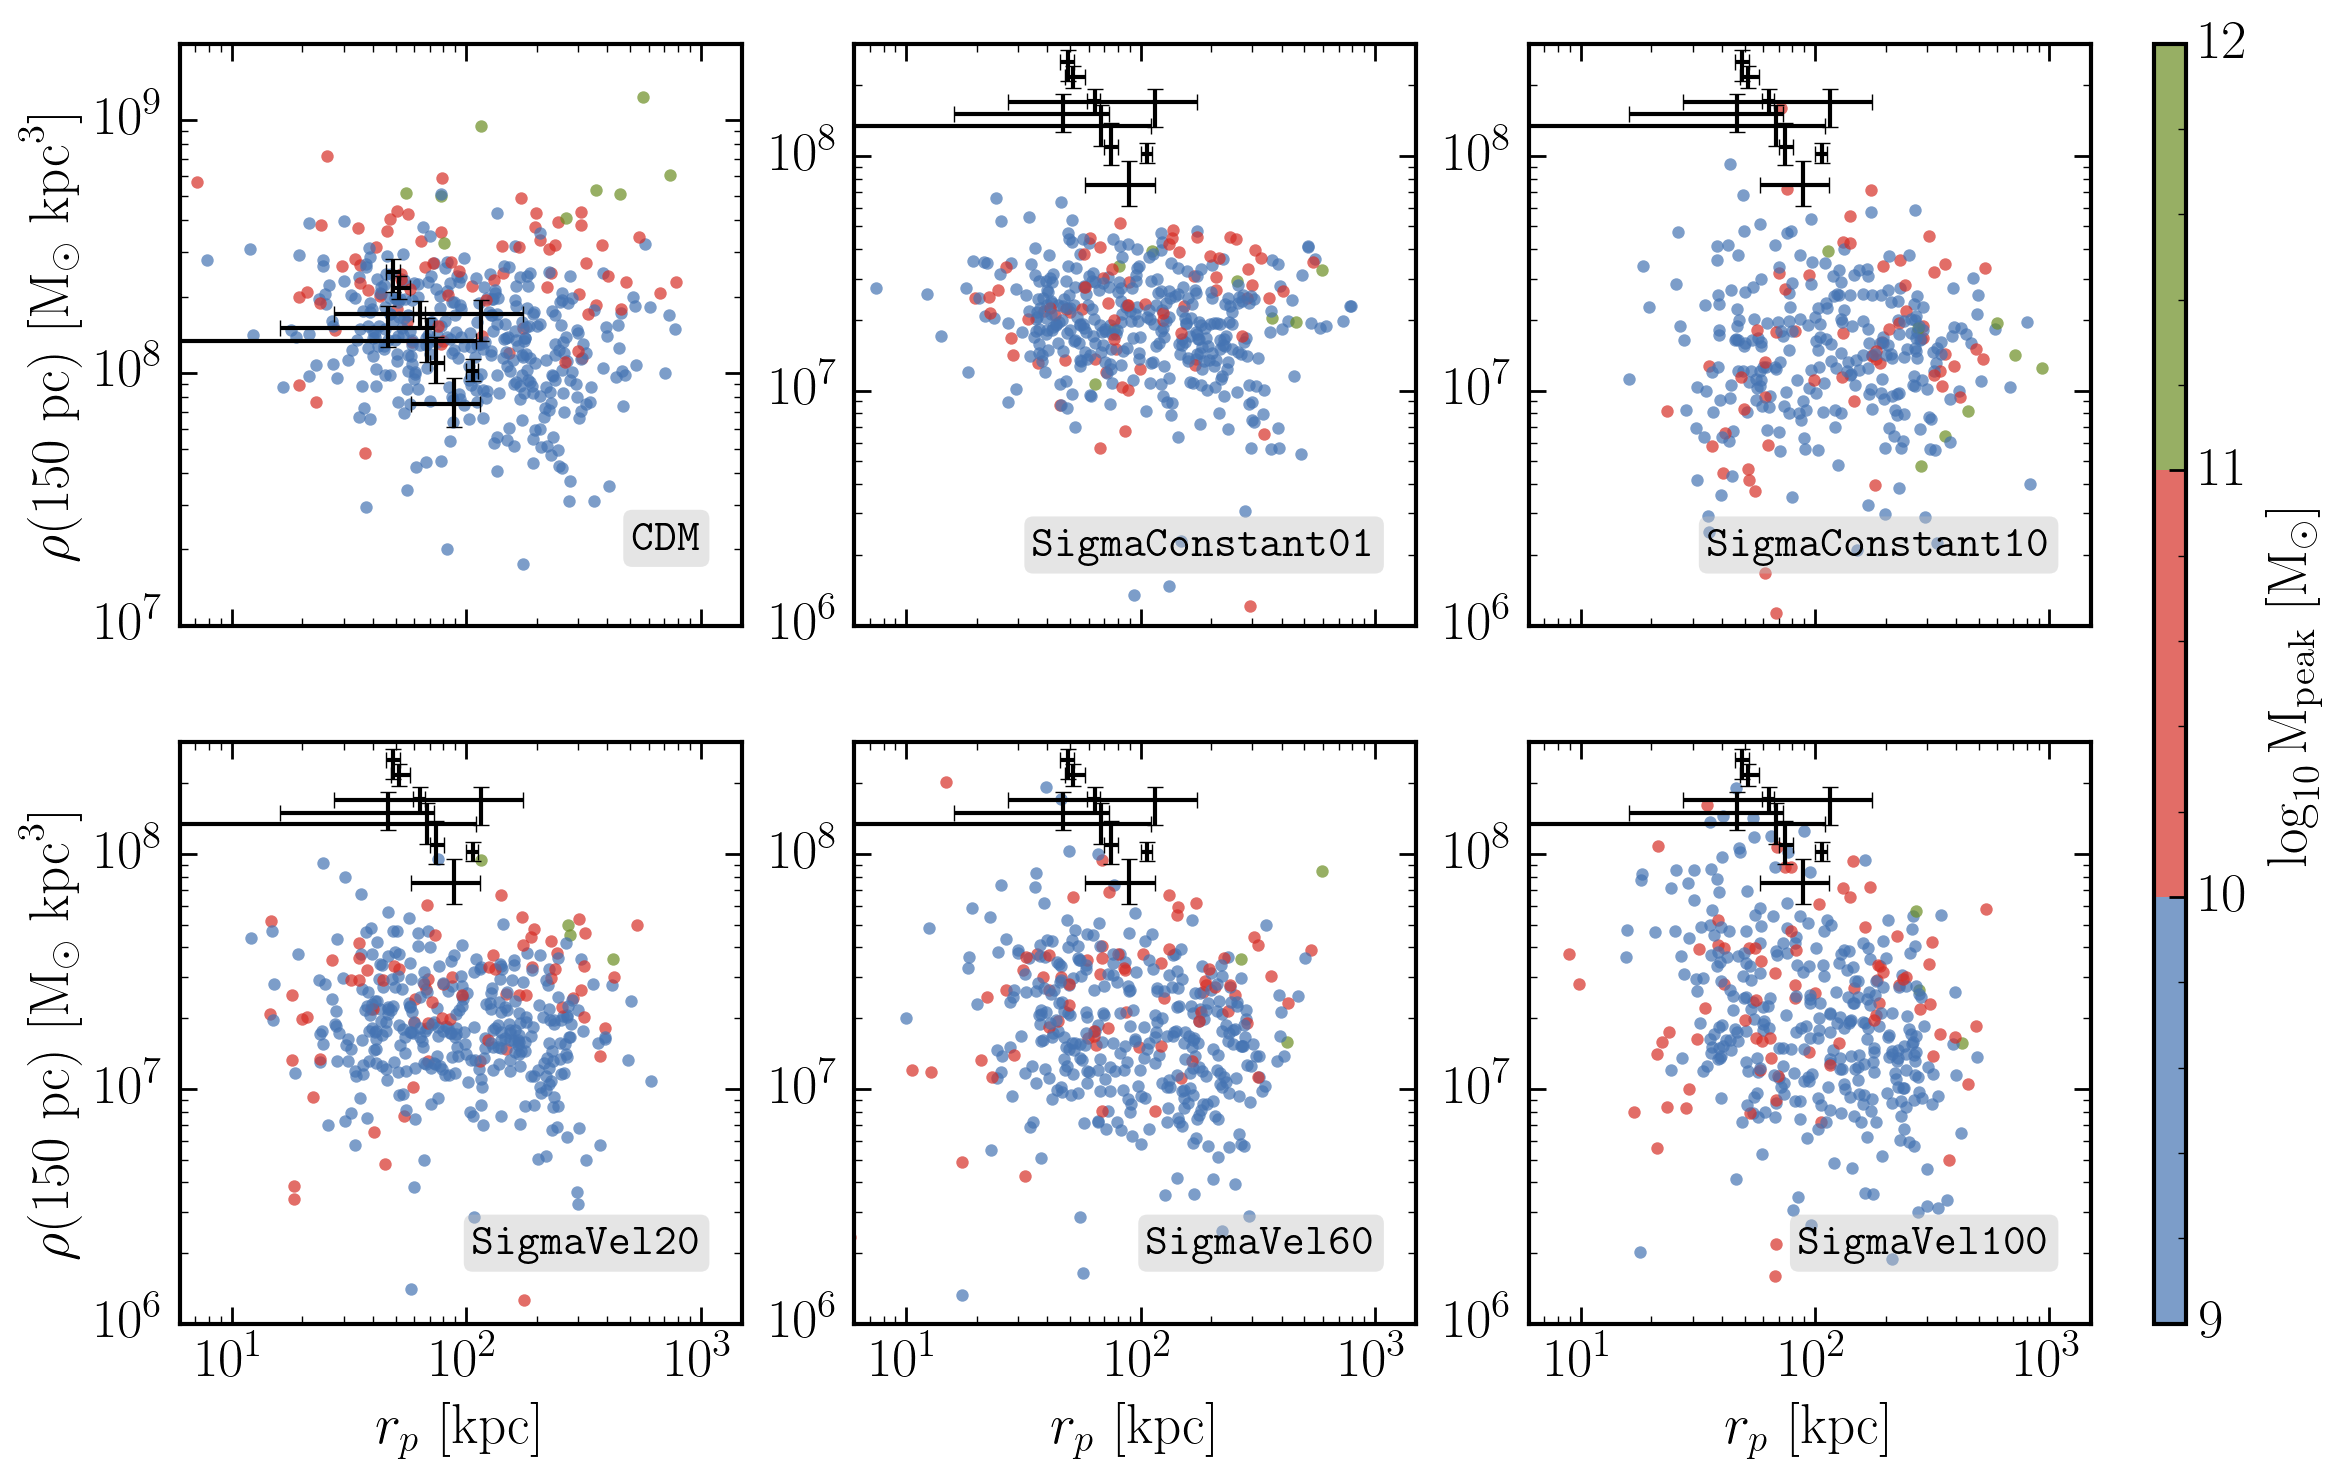

In [106]:
plot_density_150pc_with_data(colorbar_param="mass_peak", zoom=False, data=density_Kaplinghat_nfw[0], dataerr=density_Kaplinghat_nfw[1:])

In [ ]:
plot_density_150pc_with_data(colorbar_param="mass_peak", zoom=False, max10=True, data=density_Kaplinghat_nfw[0], dataerr=density_Kaplinghat_nfw[1:])

#### Plotting routine B

- `colorbar_param`: points can be color coded with a colorbar by `accretion` (accretion redshift), `mass_peak` (peak mass), `mass_0` (bounded mass at z=0), and `mass_parent` (the virial mass of the parent host halo).

- `zoom` (bool): if True makes x and y axis limits smaller, zooming in the region where datapoints are.

- `max10` (bool): if True only considers the 10 most massive satellites per host halos.

<mark>The inner density measurment points from Gaia data comes from Kaplinghat 2019 fit, with NFW (`density_Kaplinghat_nfw`) for CDM, and with isothermal (`density_Kaplinghat_iso`) for the other cases. The pericenter data comes from `pericenter_Battaglia`.<mark>

In [115]:
def plot_density_150pc_with_data_B(colorbar_param:str, filename:str, zoom:bool=False, max10:bool=False):
    
    print(f'Plotting density at 150pc versus pericenter distance with {colorbar_param} colorbar with Gaia data!')

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=zoom, figsize=(13, 8), dpi=200, facecolor='white')
    axs = axs.flatten()

    for i, (id, id_name) in enumerate(IDs.items()):
        file = h5py.File(DATA_PATH+f"{id}.hdf5", "r")
        p_array, r_array, c_array = [], [], []
        
        # Position labels
        if zoom:
            axs[i].text(8, 5e8,  fr'$\texttt{{{id_name}}}$', color='black', 
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2')) #, horizontalalignment='right')
        else:
            if i ==0:
                axs[i].text(1e3, 2e7,  fr'$\texttt{{{id_name}}}$', color='black', 
                    bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), horizontalalignment='right')
            else:
                axs[i].text(1e3, 2e6,  fr'$\texttt{{{id_name}}}$', color='black', 
                    bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), horizontalalignment='right')
        
        # Add data
        if i ==0:
            axs[i].errorbar(x, density_Kaplinghat_nfw[0], yerr=density_Kaplinghat_nfw[1:], xerr=xerr, ls='none', c='k')
        else:
            axs[i].errorbar(x, density_Kaplinghat_iso[0], yerr=density_Kaplinghat_iso[1:], xerr=xerr, ls='none', c='k')

        # Add scatter points from simulations
        for idx in file.keys():
            if file[f'{idx}'].attrs.get('main_halo_of') is not None:
                halo_idx = idx
                data_halo = file[f'{halo_idx}']
                subhalos_idxs = file[f'{halo_idx}'].attrs.get('main_halo_of')
                
                if max10: r = min(len(subhalos_idxs), 10)
                else: r = len(subhalos_idxs)
                
                for subhalo in range(r):
                    subhalo_idx = subhalos_idxs[subhalo]
                    data_subhalo = file[f'{subhalo_idx}']

                    if np.log10(data_subhalo['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9

                        pericenter = data_subhalo['tree_data']['pericenter'][1]
                        z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']

                        if id_name == "CDM":
                            r0, rho0 = data_subhalo['halo_data']['nfw_fit']
                            density_fit = fit_nfw_model(np.array([0.15]), r0, rho0)
                            density_fit = 10**density_fit
                        else:
                            r0, rho0 = data_subhalo['halo_data']['iso_fit']
                            density_fit = fit_isothermal_model(np.array([0.15]*2), r0, rho0)[0]
                            density_fit = 10**density_fit

                        if colorbar_param == 'accretion':
                            c = accretion
                            cmap, norm = colorbar_args(colorbar_param)
                        elif colorbar_param == 'mass_0':
                            mass_0 = data_subhalo['tree_data']['bound_mass_dm'][0] 
                            c = np.log10(mass_0)
                            cmap, norm = colorbar_args(colorbar_param)
                        elif colorbar_param == 'mass_peak':
                            mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]
                            c = np.log10(mass_peak)
                            cmap, norm = colorbar_args(colorbar_param)
                        elif colorbar_param == 'mass_parent':
                            mass_parent = data_halo['tree_data']['bound_mass_dm'][0] 
                            c = np.log10(mass_parent)
                            vmin, vmax = np.log10(6e11), np.log10(2e12)
                            cmap =  matplotlib.colors.ListedColormap(matplotlib.cm.Blues(np.linspace(0.2, 1, 5)))
                            norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=((vmax+vmin)/2), vmax=vmax)
                
                        p = pericenter[0] if pericenter.shape==(1,) else pericenter
                        im = axs[i].scatter(x=pericenter, y=density_fit, marker='o', linewidths=0, 
                                            c=c, cmap=cmap, norm=norm, alpha=0.7)
                        p_array.append(p)
                        r_array.append(density_fit)
                        c_array.append(c)
                                
        file.close()

        #Let's add median trends..
        p_bins = np.arange(1, 3, 0.3)
        p_bins = 10**p_bins
        num_bins = len(p_bins)
        p_array = np.array(p_array)
        r_array = np.array(r_array)
        c_array = np.array(c_array)
        indx = np.digitize(p_array, p_bins)
        p_bins_medians = np.array([np.median(p_array[indx == idx]) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
        r_bins_medians = np.array([np.median(r_array[indx == idx]) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
        r_bins_16 = np.array([np.percentile(r_array[indx == idx], 16) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
        r_bins_84 = np.array([np.percentile(r_array[indx == idx], 84) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])

        color='grey'
        axs[i].plot(p_bins_medians, r_bins_medians, lw=3, color='white')
        axs[i].plot(p_bins_medians, r_bins_medians, color=color)
        axs[i].plot(p_bins_medians, r_bins_16, '--', color=color)
        axs[i].plot(p_bins_medians, r_bins_84,  '--',color=color)
        axs[i].fill_between(
            p_bins_medians,
            r_bins_16,
            r_bins_84,
            color=color,
            alpha=0.15,
        )
                      
    # axis stuff
    for i, ax in enumerate(axs):
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if zoom:
            ax.set_xlim(6e0, 1e3)
            ax.set_ylim(1e6, 1e9)
        else: 
            ax.set_xlim(6e0, 1e3)
            # if i ==0:
            #     ax.set_ylim(1e7, 2e9)
            # else:
            ax.set_ylim(1e6, 1e9)
            
    for axi in [3, 4, 5]:
        axs[axi].set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    for axi in [0, 3]:
        axs[axi].set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^3]$')
                
    # colorbar stuff
    if colorbar_param == "accretion":
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=COLORBAR_DICT[colorbar_param], aspect=40, fraction=0.02, pad=0.04)
        cbar.ax.set_yticks([0, 1, 2]) 
    elif colorbar_param in ["mass_0", "mass_peak"]:
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=COLORBAR_DICT[colorbar_param], aspect=40, fraction=0.02, pad=0.04)
        cbar.ax.set_yticks([9, 10, 11, 12]) 
    elif colorbar_param == "mass_parent":
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=fr'$\log_{{10}}\mathrm{{M_{{200c, central}}}}$ $\mathrm{{[M_\odot]}}$',
                        aspect=40, fraction=0.02, pad=0.04)
        
    if zoom:
        plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)
    else:
        plt.subplots_adjust(hspace=0.2, wspace=0.2, right=.86)
    fig.savefig(filename,dpi=300)
    plt.show()

Plotting density at 150pc versus pericenter distance with accretion colorbar with Gaia data!


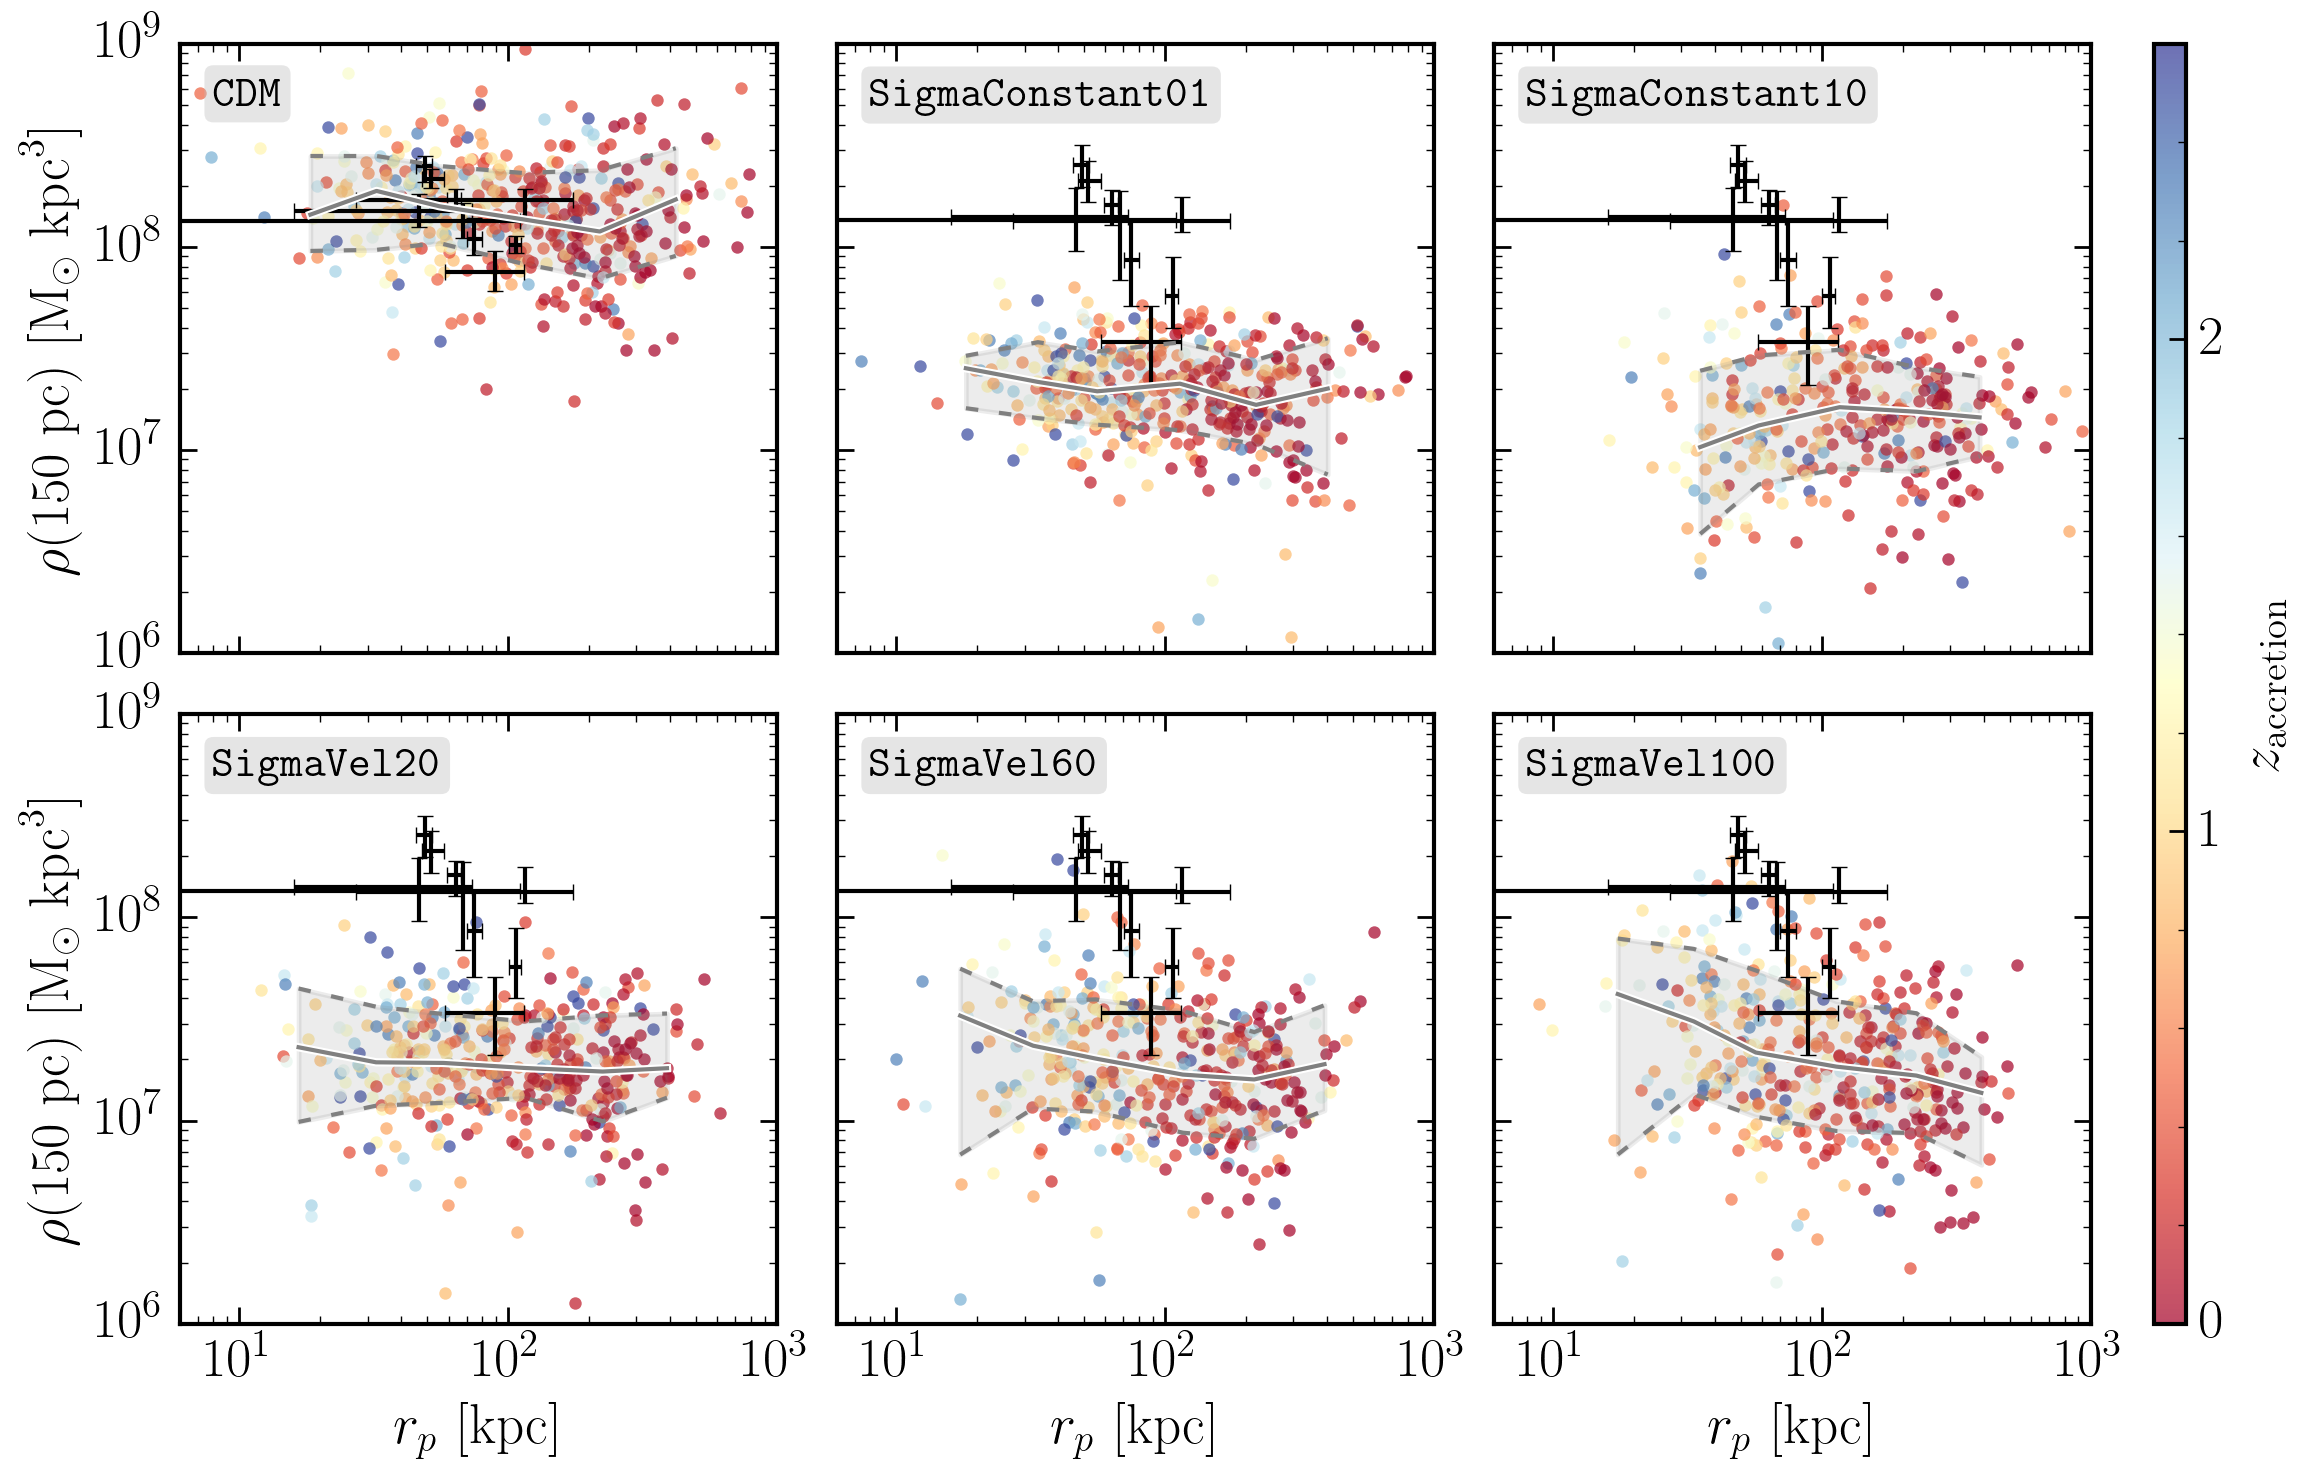

In [118]:
plot_density_150pc_with_data_B(colorbar_param="accretion", filename="density_150pc_allmodels_accretion.png",zoom=True)

In [ ]:
plot_density_150pc_with_data_B(colorbar_param="mass_peak", zoom=True)

In [ ]:
plot_density_150pc_with_data_B(colorbar_param="mass_peak", zoom=True, max10=True)

#### Plotting routine C (just CDM and SigmaVel100)

- `colorbar_param`: points can be color coded with a colorbar by `accretion` (accretion redshift), `mass_peak` (peak mass), `mass_0` (bounded mass at z=0), and `mass_parent` (the virial mass of the parent host halo).

- `max10` (bool): if True only considers the 10 most massive satellites per host halos.

<mark>The inner density measurment points from Gaia data comes from Kaplinghat 2019 fit, with NFW (`density_Kaplinghat_nfw`) for CDM, and with isothermal (`density_Kaplinghat_iso`) for the other cases. The pericenter data comes from `pericenter_Battaglia`.<mark>

In [100]:
def plot_density_150pc_with_data_C(colorbar_param:str, filename:str, max10:bool=False):

    print(f'Plotting density at 150pc versus pericenter distance with {colorbar_param} colorbar with Gaia data!')

    fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5, 12.5), dpi=200, facecolor='white')
    axs = axs.flatten()

    p_bins = np.arange(1, 3, 0.3)
    p_bins = 10**p_bins
    num_bins = len(p_bins)

    for j, (id, id_name) in enumerate(IDs.items()):
        if id_name in ["CDM", "SigmaVel100"]:
            if id_name == "CDM": i =0
            elif id_name == "SigmaVel100": i =1
                
            p_array, r_array, c_array = [], [], []

            if id_name=="CDM":
                axs[i].text(8, 1.1e9,  fr'$\texttt{{{id_name}}}$', color='black', 
                    bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2')) #, horizontalalignment='right')
                axs[i].errorbar(x, density_Kaplinghat_nfw[0], yerr=density_Kaplinghat_nfw[1:], xerr=xerr, ls='none', c='k')
            else:
                axs[i].text(8, 4.5e8,  fr'$\texttt{{{id_name}}}$', color='black', #1.5e8
                    bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2')) #, horizontalalignment='right')
                axs[i].errorbar(x, density_Kaplinghat_iso[0], yerr=density_Kaplinghat_iso[1:], xerr=xerr, ls='none', c='k')

            file = h5py.File(DATA_PATH+f"{id}.hdf5", "r")
            for idx in file.keys():
                if file[f'{idx}'].attrs.get('main_halo_of') is not None:
                    halo_idx = idx
                    data_halo = file[f'{halo_idx}']
                    subhalos_idxs = file[f'{halo_idx}'].attrs.get('main_halo_of')

                    if max10: r = min(len(subhalos_idxs), 10)
                    else: r = len(subhalos_idxs)
                    
                    for subhalo in range(r):
                        subhalo_idx = subhalos_idxs[subhalo]
                        data_subhalo = file[f'{subhalo_idx}']

                        if np.log10(data_subhalo['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                            pericenter = data_subhalo['tree_data']['pericenter'][1]
                            z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']

                            if id_name == "CDM":
                                r0, rho0 = data_subhalo['halo_data']['nfw_fit']
                                density_fit = fit_nfw_model(np.array([0.15]), r0, rho0)
                                density_fit = 10**density_fit
                            else:
                                r0, rho0 = data_subhalo['halo_data']['iso_fit']
                                density_fit = fit_isothermal_model(np.array([0.15]*2), r0, rho0)[0]
                                density_fit = 10**density_fit

                            if colorbar_param == 'accretion':
                                c = accretion
                                cmap, norm = colorbar_args(colorbar_param)
                            elif colorbar_param == 'mass_0':
                                mass_0 = data_subhalo['tree_data']['bound_mass_dm'][0] 
                                c = np.log10(mass_0)
                                mycmap = matplotlib.cm.RdYlBu
                                myblue = mycmap(0.1)
                                myred =  mycmap(0.9)
                                vmin, vmax = 9, 12
                                cmap = matplotlib.colors.ListedColormap(['tab:orange', myred, myblue,'darkblue', "olivedrab","darkgreen"])
                                norm = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.6, vmax=12)
                                #cmap, norm = colorbar_args(colorbar_param)
                            elif colorbar_param == 'mass_peak':
                                mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]
                                c = np.log10(mass_peak)
                                mycmap = matplotlib.cm.RdYlBu
                                myblue = mycmap(0.1)
                                myred =  mycmap(0.9)
                                vmin, vmax = 9, 12
                                cmap = matplotlib.colors.ListedColormap(['tab:orange', myred, myblue,'darkblue', "olivedrab","darkgreen"])
                                norm = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.6, vmax=12)
                                # cmap, norm = colorbar_args(colorbar_param)
                            elif colorbar_param == 'mass_parent':
                                mass_parent = data_halo['tree_data']['bound_mass_dm'][0] 
                                c = np.log10(mass_parent)
                                vmin, vmax = np.log10(6e11), np.log10(2e12)
                                cmap =  matplotlib.colors.ListedColormap(matplotlib.cm.Blues(np.linspace(0.2, 1, 5)))
                                norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=((vmax+vmin)/2), vmax=vmax)

                            p = pericenter[0] if pericenter.shape==(1,) else pericenter
                            if p>6 and p<1.5e3:
                                im = axs[i].scatter(x=pericenter, y=density_fit, marker='o', linewidths=0, 
                                                    c=c, cmap=cmap, norm=norm, alpha=0.7)
                                p_array.append(p)
                                r_array.append(density_fit)
                                c_array.append(c)

            #num_bins = 10
            p_array = np.array(p_array)
            r_array = np.array(r_array)
            c_array = np.array(c_array)
            
            if colorbar_param in ['accretion', 'mass_parent', 'mass_0', 'mass_peak']:
                #if i == 0: # use same binning everywhere
                #    p_bins = np.logspace(np.log10(20), np.log10(600), num_bins)
                #r_bins_value = [r_array[np.digitize(p_array, np.logspace(np.log10(20), np.log10(600), num_bins + 1)) == i] for i in range(1, num_bins + 1)]
                #r_bins_medians = np.array([np.median(bin_y) for bin_y in r_bins_value])
                #r_bins_16 = np.array([np.percentile(bin_y, 16) for bin_y in r_bins_value])
                #r_bins_84 = np.array([np.percentile(bin_y, 84) for bin_y in r_bins_value])   

                # select = np.where((c_array <= 10.5)&(c_array >= 9.5))[0]
                # p_array = p_array[select]
                # r_array = r_array[select]
                
                
                indx = np.digitize(p_array, p_bins)#, right=True)
                p_bins_medians = np.array([np.median(p_array[indx == idx]) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
                r_bins_medians = np.array([np.median(r_array[indx == idx]) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
                r_bins_16 = np.array([np.percentile(r_array[indx == idx], 16) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
                r_bins_84 = np.array([np.percentile(r_array[indx == idx], 84) for idx in np.arange(num_bins) if len(p_array[indx==idx])>5])
    
                color='grey'
                #color='darkgoldenrod'
                axs[i].plot(p_bins_medians, r_bins_medians, lw=3, color='white')
                axs[i].plot(p_bins_medians, r_bins_medians, color=color)
                axs[i].plot(p_bins_medians, r_bins_16, '--', color=color)
                axs[i].plot(p_bins_medians, r_bins_84,  '--',color=color)
                axs[i].fill_between(
                    p_bins_medians,
                    r_bins_16,
                    r_bins_84,
                    color=color,
                    alpha=0.2,
                )

        file.close() 

    # axis stuff
    for i, ax in enumerate(axs):
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(6e0, 1.5e3)
        ax.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^3]$')

    axs[1].set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    axs[0].set_ylim(1e7, 2e9)
    axs[1].set_ylim(1e6, 8e8)
  
    # colorbar stuff
    if colorbar_param == "accretion":
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=COLORBAR_DICT[colorbar_param], location='top')
        cbar.ax.set_xticks([0, 1, 2]) 
    elif colorbar_param in ["mass_0", "mass_peak"]:
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=COLORBAR_DICT[colorbar_param], location='top')
        cbar.ax.set_xticks([9, 9.2, 9.4, 9.6, 10.2, 11, 12]) 
    elif colorbar_param == "mass_parent":
        cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label=fr'$\log_{{10}}\mathrm{{M_{{200c, central}}}}$ $\mathrm{{[M_\odot]}}$',
                        location='top')
        
    plt.subplots_adjust(hspace=0.05, top=0.76)
    fig.savefig(filename,dpi=300)
    plt.show()


Plotting density at 150pc versus pericenter distance with mass_0 colorbar with Gaia data!


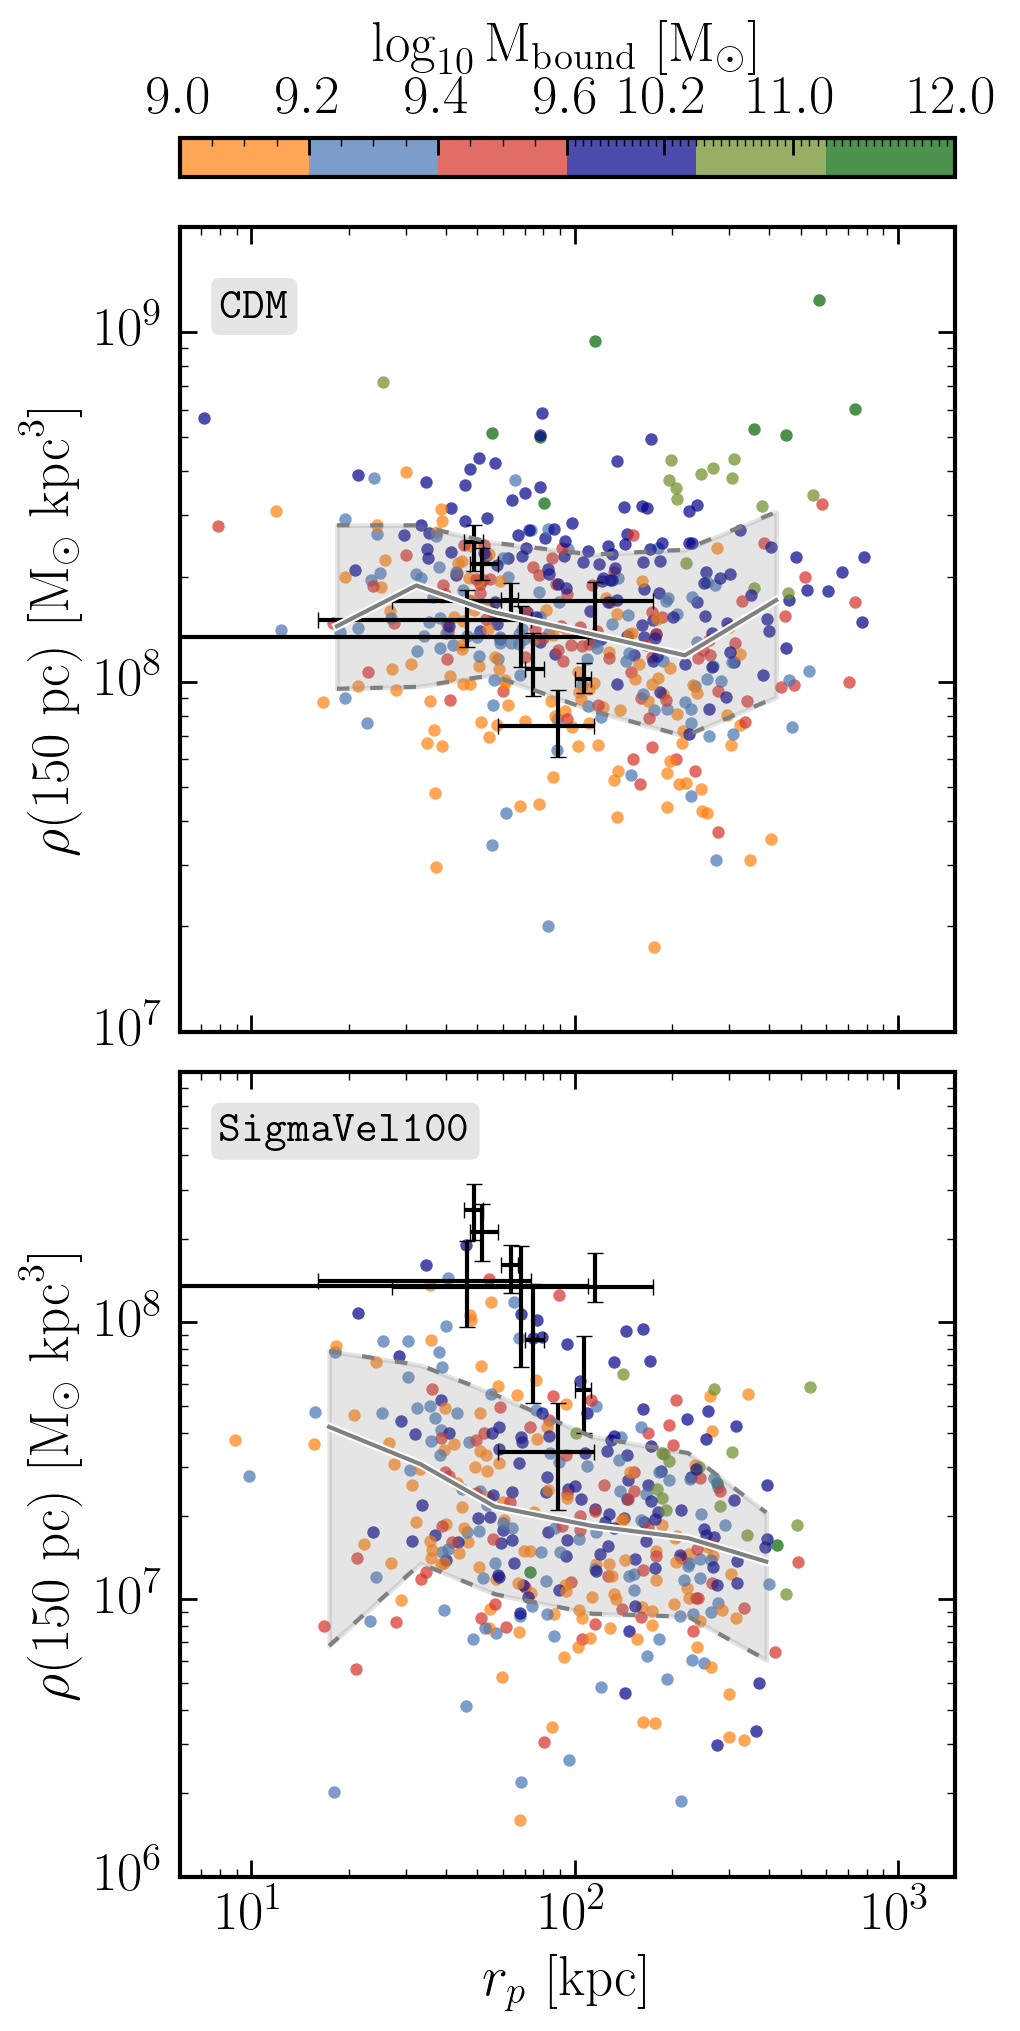

In [101]:
#plot_density_150pc_with_data_C(colorbar_param="mass_peak", max10=True)
plot_density_150pc_with_data_C(colorbar_param="mass_0", filename="density_150pc_CDM_SigmaVel100_massbound.png")

Plotting density at 150pc versus pericenter distance with mass_peak colorbar with Gaia data!


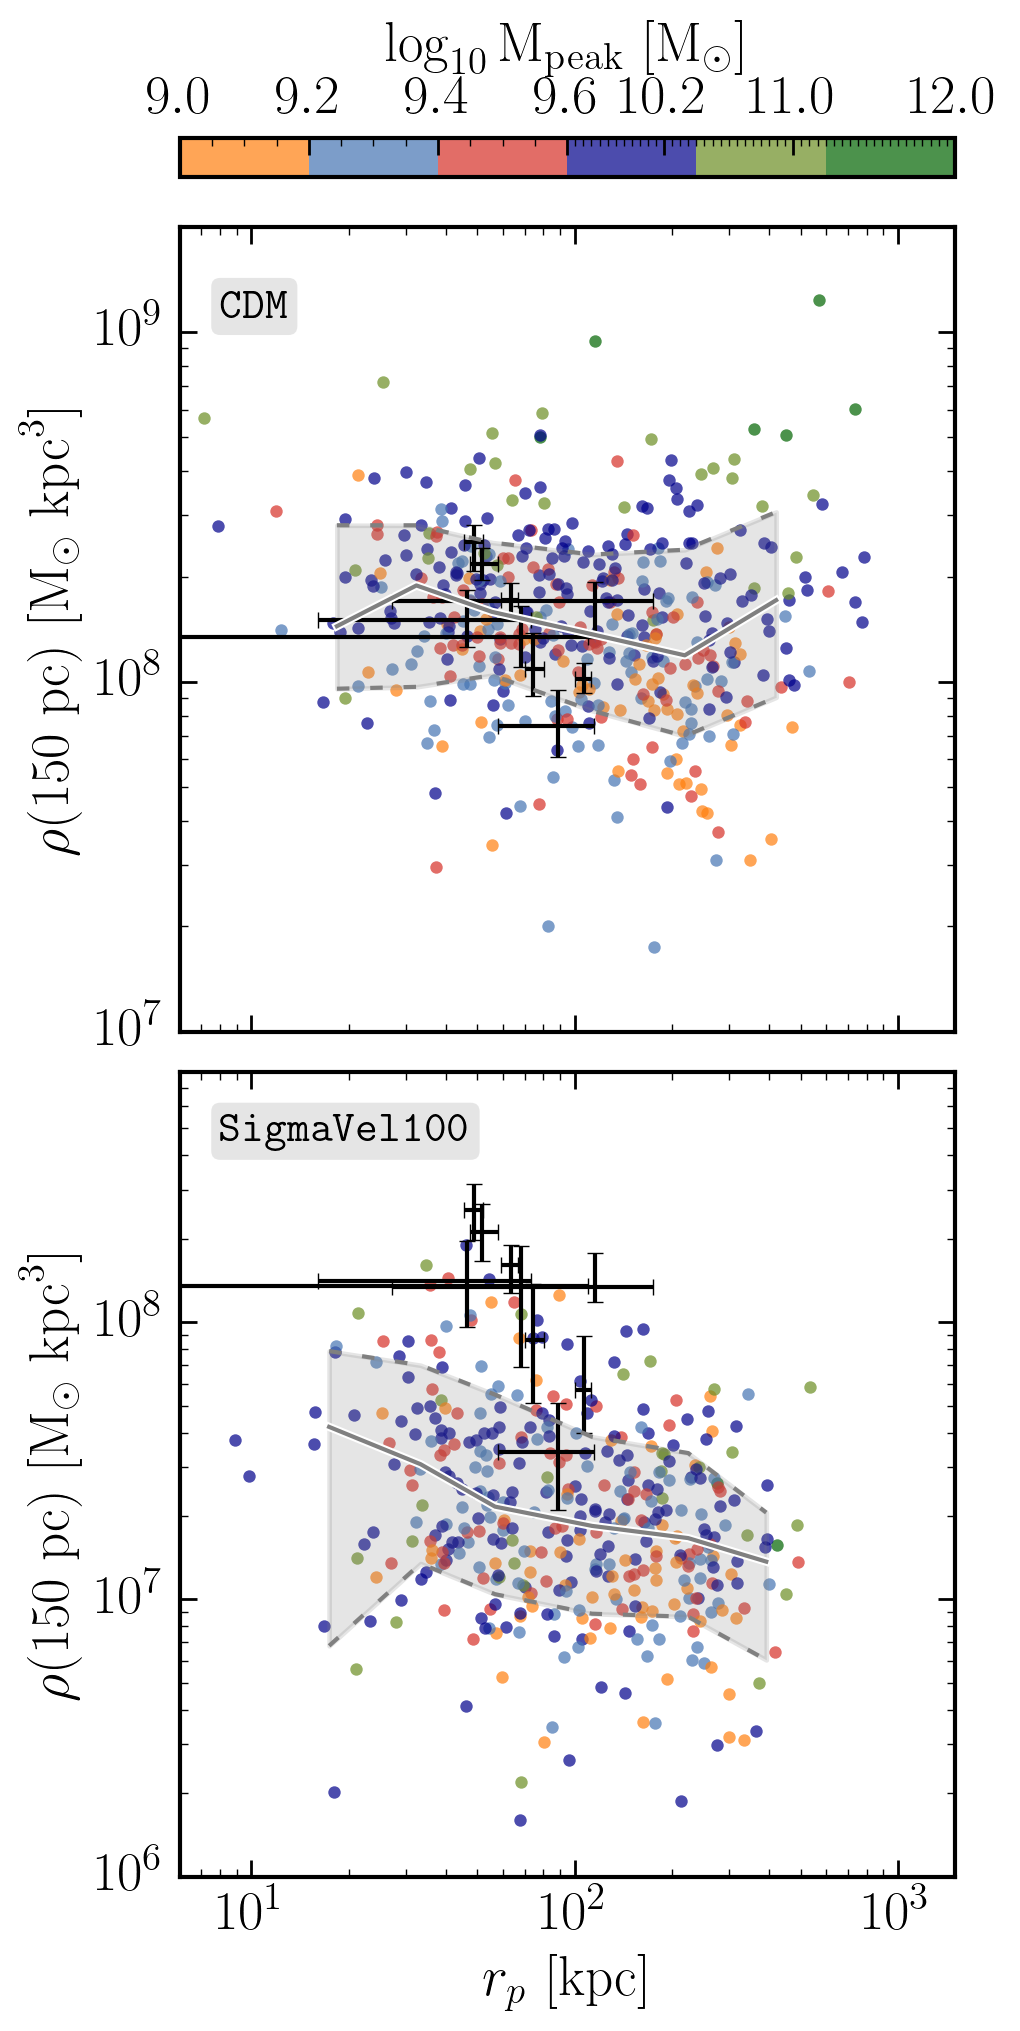

In [102]:
plot_density_150pc_with_data_C(colorbar_param="mass_peak", filename="density_150pc_CDM_SigmaVel100_masspeak.png")

Plotting density at 150pc versus pericenter distance with mass_parent colorbar with Gaia data!


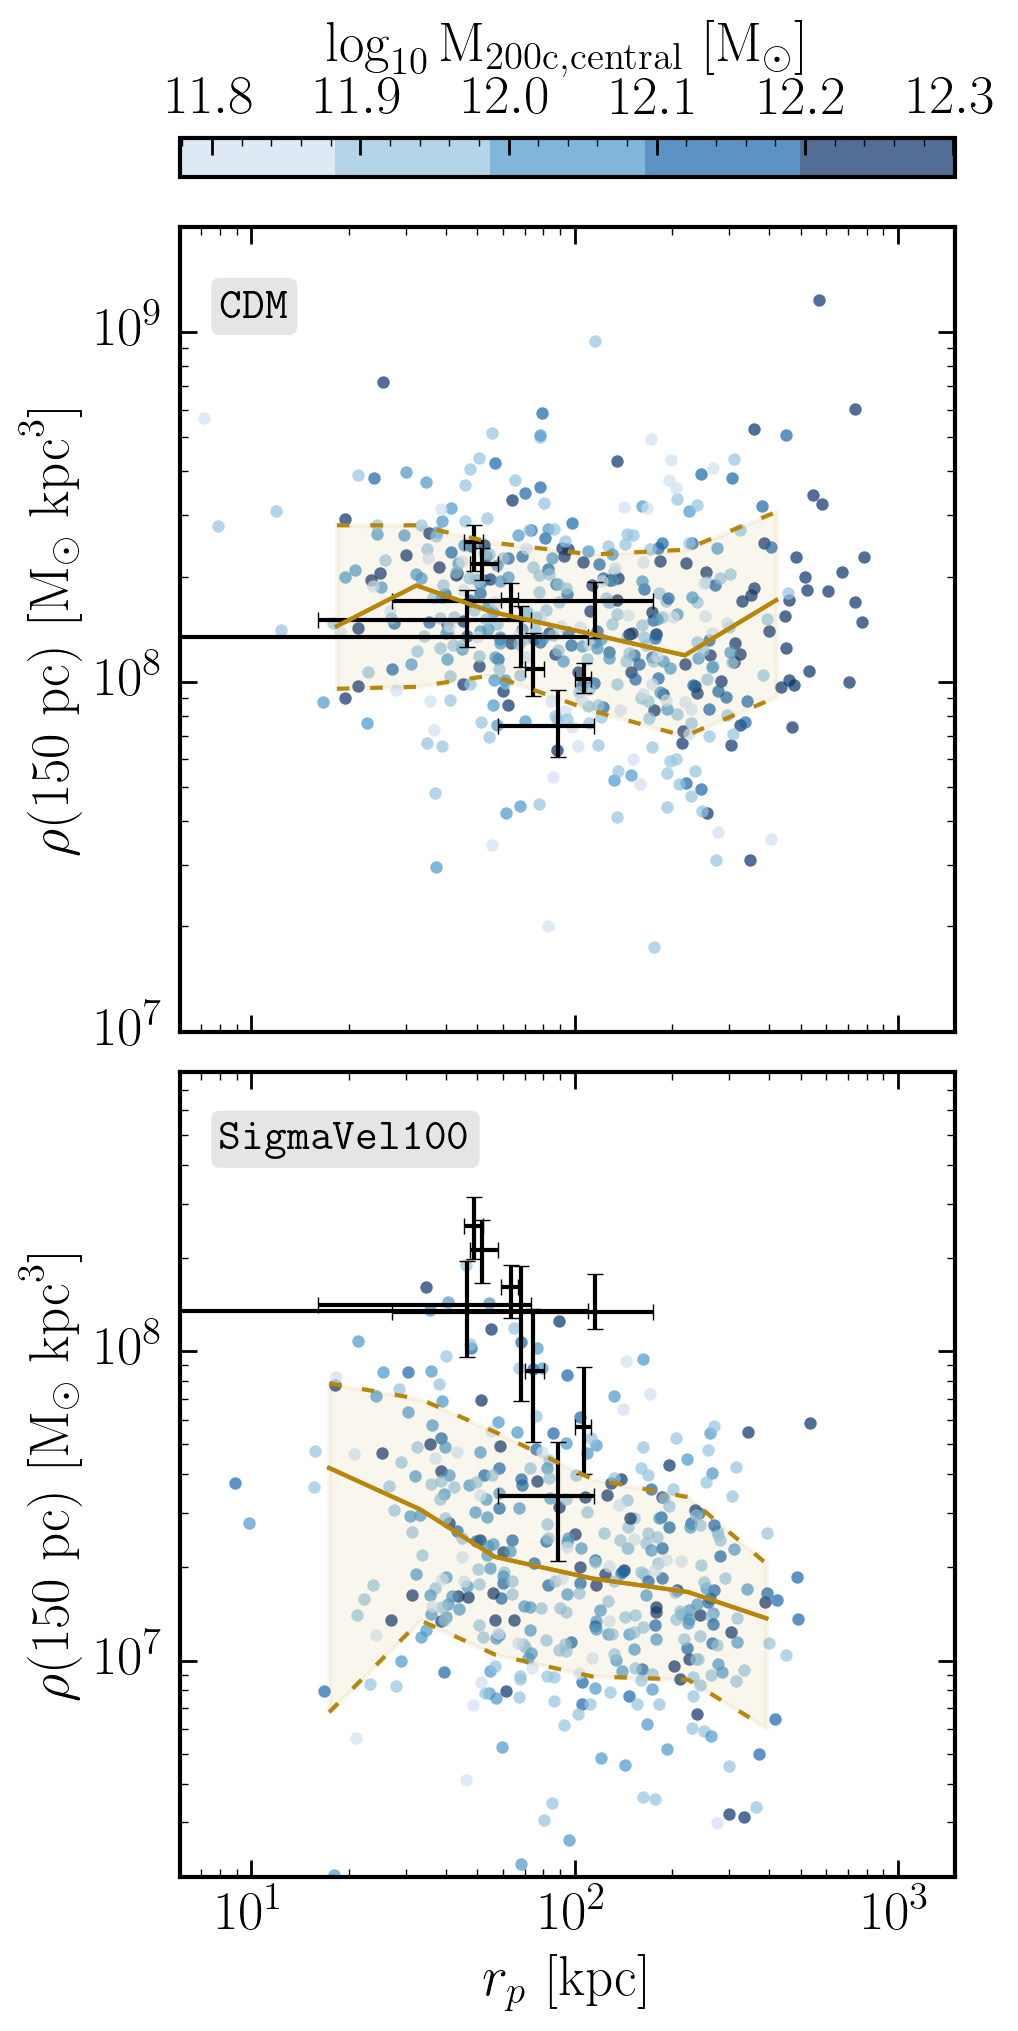

In [7]:
plot_density_150pc_with_data_C(colorbar_param="mass_parent")

#### Plotting routine D

- `max10` (bool): if True only considers the 10 most massive satellites per host halos.

Measurment points from all Gaia measurments (`density_Andrade`, `density_Hayashi`, `density_Kaplinghat_nfw`, `density_Kaplinghat_iso`, `density_Read`). The pericenter data comes from `pericenter_Battaglia`.<mark>

In [107]:
def plot_density_150pc_with_data_D(max10:bool=False):
    
    print(f'Plotting density at 150pc versus pericenter distance with Gaia data!')

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
    axs = axs.flatten()

    for i, (id, id_name) in enumerate(IDs.items()):
        file = h5py.File(DATA_PATH+f"{id}.hdf5", "r")
        
        # Position labels
        axs[i].text(1e3, 2e6,  fr'$\texttt{{{id_name}}}$', color='black', 
            bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), horizontalalignment='right')
        
        # Add data
        axs[i].errorbar(x, density_Andrade[0], yerr=density_Andrade[1:], xerr=xerr, ls='none', c=myred, alpha=0.8, label=r'$\mathrm{Andrade+2023}$')
        axs[i].errorbar(x, density_Hayashi[0], yerr=density_Hayashi[1:], xerr=xerr, ls='none', c=myblue, alpha=0.8, label=r'$\mathrm{Hayashi+2020}$')
        axs[i].errorbar(x, density_Kaplinghat_nfw[0], yerr=density_Kaplinghat_nfw[1:], xerr=xerr, ls='none', c='olivedrab', alpha=0.8, label=r'$\mathrm{Kaplinghat+2019\ (NFW)}$')
        axs[i].errorbar(x, density_Kaplinghat_iso[0], yerr=density_Kaplinghat_iso[1:], xerr=xerr, ls='none', c='peru', alpha=0.8, label=r'$\mathrm{Kaplinghat+2019\ (iso)}$')
        axs[i].errorbar(x, density_Read[0], yerr=density_Read[1:], xerr=xerr, ls='none', c='darkorchid', alpha=0.8, label=r'$\mathrm{Read+2019}$')

        # Add scatter points from simulations
        for idx in file.keys():
            if file[f'{idx}'].attrs.get('main_halo_of') is not None:
                halo_idx = idx
                data_halo = file[f'{halo_idx}']
                subhalos_idxs = file[f'{halo_idx}'].attrs.get('main_halo_of')
                
                if max10: r = min(len(subhalos_idxs), 10)
                else: r = len(subhalos_idxs)
                
                for subhalo in range(r):
                    subhalo_idx = subhalos_idxs[subhalo]
                    data_subhalo = file[f'{subhalo_idx}']

                    if np.log10(data_subhalo['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9

                        pericenter = data_subhalo['tree_data']['pericenter'][1]
                        z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']

                        if id_name == "CDM":
                            r0, rho0 = data_subhalo['halo_data']['nfw_fit']
                            density_fit = fit_nfw_model(np.array([0.15]), r0, rho0)
                            density_fit = 10**density_fit
                        else:
                            r0, rho0 = data_subhalo['halo_data']['iso_fit']
                            density_fit = fit_isothermal_model(np.array([0.15]*2), r0, rho0)[0]
                            density_fit = 10**density_fit

                        axs[i].scatter(x=pericenter, y=density_fit, marker='+', linewidths=0.3, 
                                            c='k', alpha=0.6)
                                
        file.close() 
                      
    # axis stuff
    for i, ax in enumerate(axs):
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(6e0, 1.5e3)
        ax.set_ylim(1e6, 2e9)
        
    for axi in [3, 4, 5]:
        axs[axi].set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    for axi in [0, 3]:
        axs[axi].set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^3]$')

    axs[0].legend(fontsize=11, numpoints=1);
    plt.subplots_adjust(hspace=0.2, wspace=0.2, right=.86)
    plt.show()

Plotting density at 150pc versus pericenter distance with Gaia data!


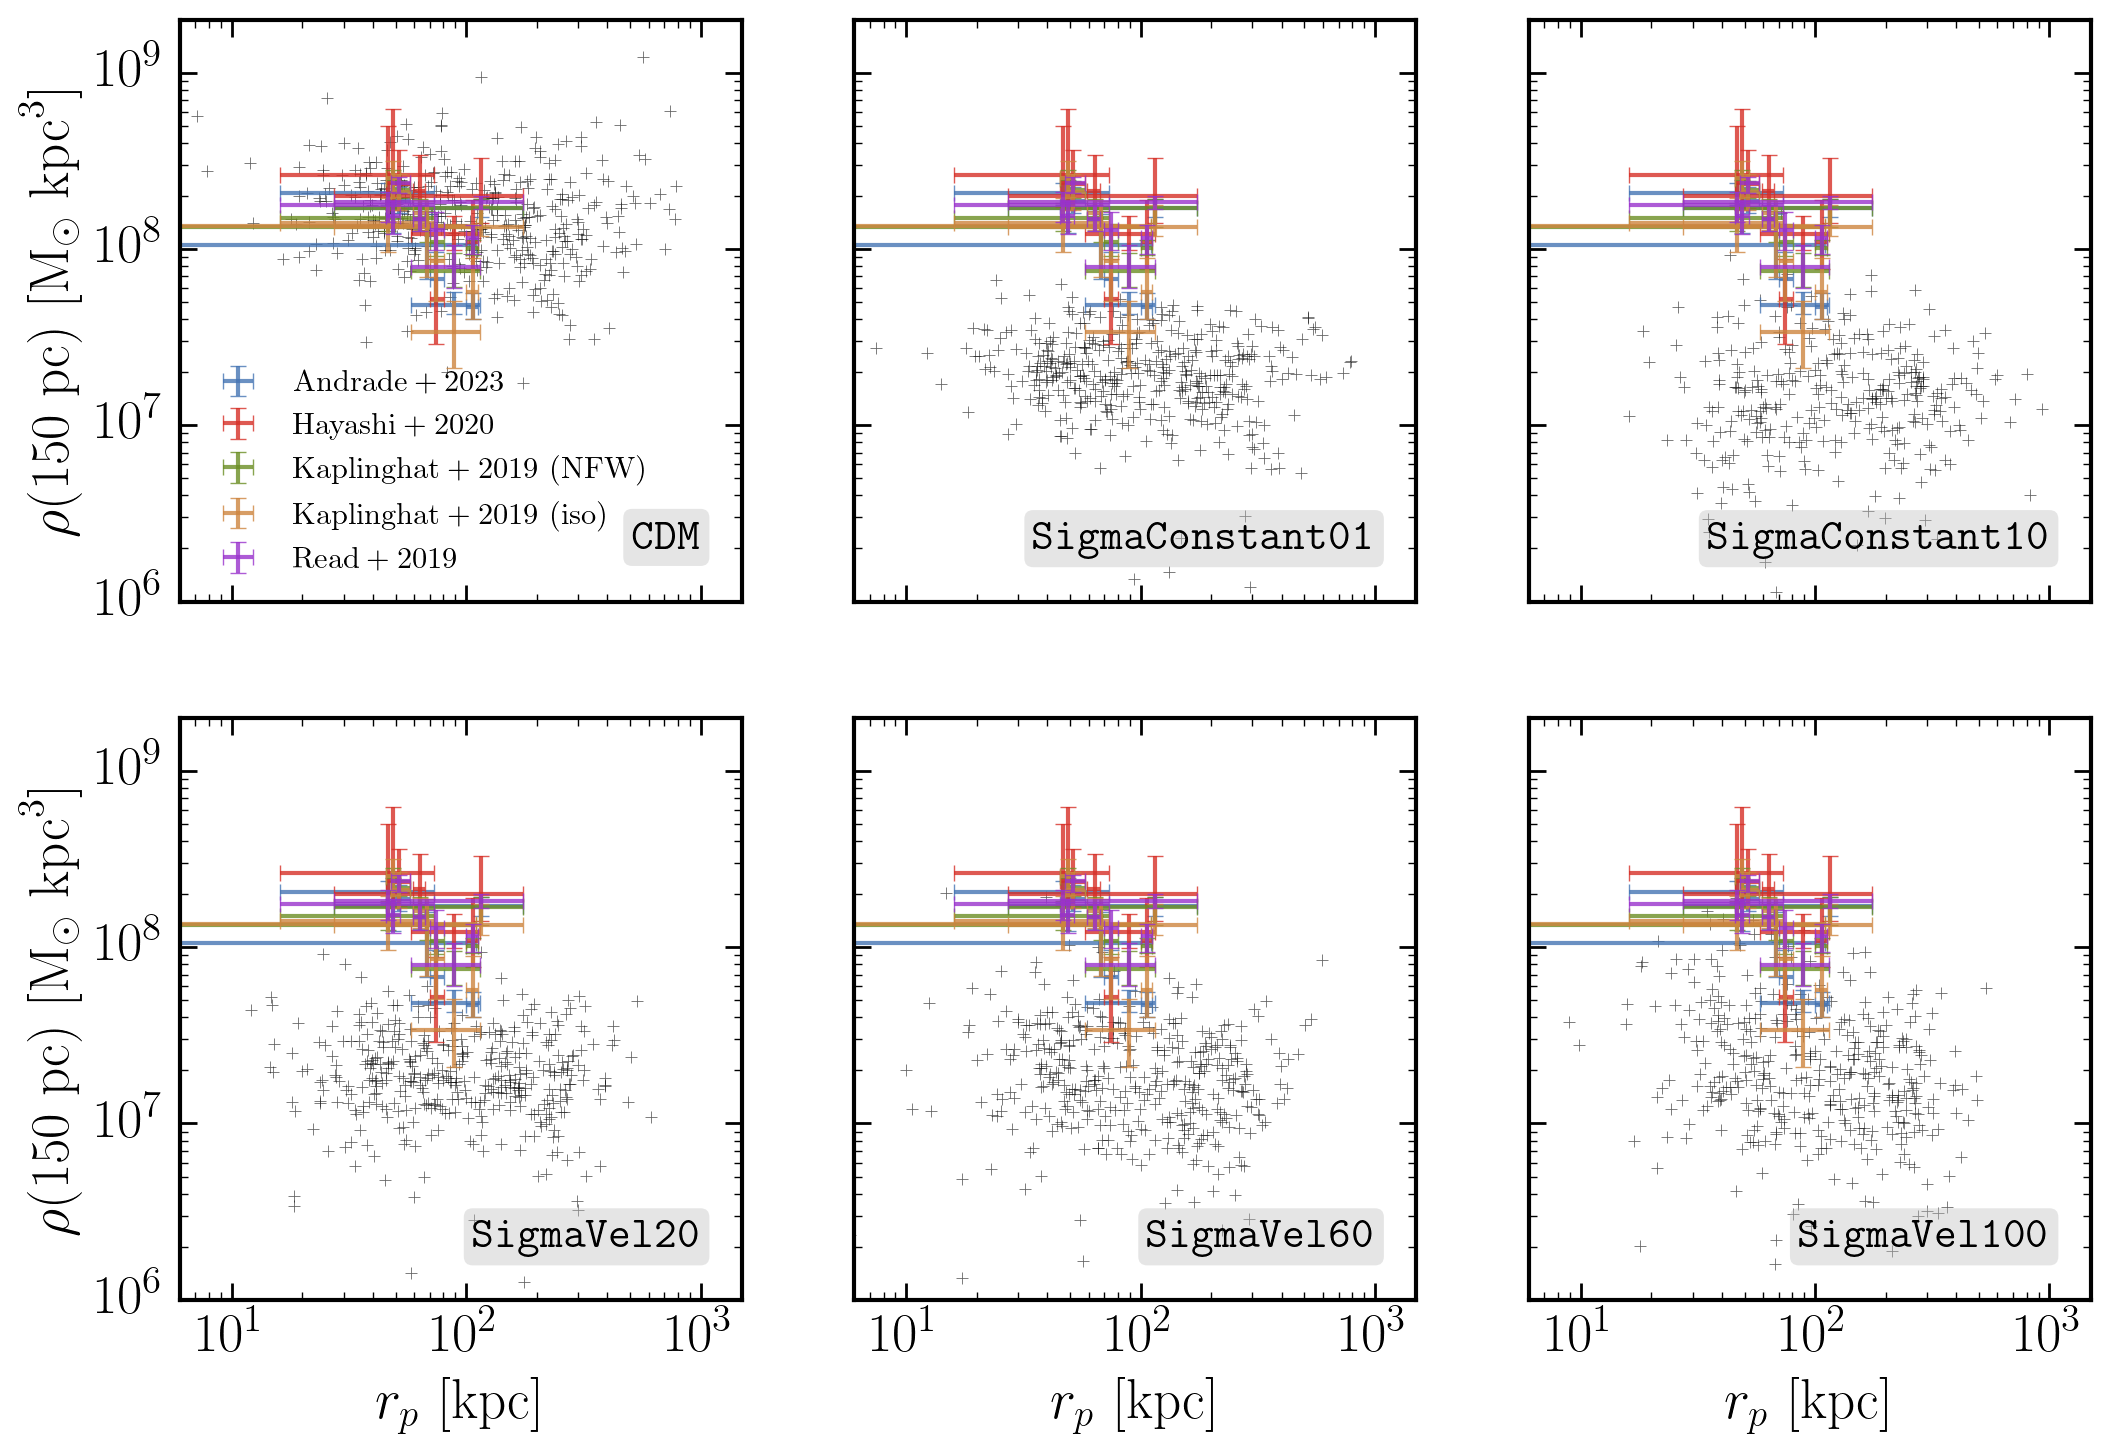

In [108]:
plot_density_150pc_with_data_D()

In [ ]:
plot_density_150pc_with_data_D(max10=True)